In [2]:
!pip install torchinfo

# Error Analysis

1. Computational Complexity

In [5]:
import torch
import torch.nn as nn
import timm
from transformers import AutoModelForImageClassification
from torchinfo import summary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_from_disk
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader

In [ ]:
# We dont need the trained models, just look at the architectures
# COPIED from the cnn scratch model:
class BirdCNN(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.classifier(x)

device = "cpu"

# Simple CNN
cnn_model = BirdCNN(num_classes=200)

# Our hugging face baseline:
baseline_model = AutoModelForImageClassification.from_pretrained(
    "google/mobilenet_v2_1.0_224", num_labels=200, ignore_mismatched_sizes=True
)

# Our main model (coatnet)
coatnet_model = timm.create_model("coatnet_0_rw_224", pretrained=False, num_classes=200)

def get_stats(model, model_name):
    stats = summary(model, input_size=(1, 3, 224, 224), verbose=0)
    params = stats.total_params
    # FLOPPPPP
    flops = stats.total_mult_adds
    
    print(f"--- {model_name} ---")
    print(f"Parameters: {params:,}")
    print(f"FLOPs (Approx): {flops:,}")
    print(f"Size (MB): {stats.to_megabytes(params):.2f}")
    return params, flops

print("COMPUTATIONAL COMPLEXITY ANALYSIS\n")
cnn_p, cnn_f = get_stats(cnn_model, "Simple CNN")
base_p, base_f = get_stats(baseline_model, "Baseline (MobileNetV2)")
coat_p, coat_f = get_stats(coatnet_model, "CoAtNet-0 (Main)")

print("\n--- COMPARISON ---")
print(f"CoAtNet vs CNN Params: {coat_p / cnn_p:.1f}x larger")
print(f"CoAtNet vs Baseline Params: {coat_p / base_p:.1f}x larger")

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([200, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


COMPUTATIONAL COMPLEXITY ANALYSIS

--- Simple CNN ---
Parameters: 508,104
FLOPs (Approx): 817,184,136
Size (MB): 0.51
--- Baseline (MobileNetV2) ---
Parameters: 2,480,072
FLOPs (Approx): 299,784,584
Size (MB): 2.48
--- CoAtNet-0 (Main) ---
Parameters: 26,820,362
FLOPs (Approx): 4,213,652,296
Size (MB): 26.82

--- COMPARISON ---
CoAtNet vs CNN Params: 52.8x larger
CoAtNet vs Baseline Params: 10.8x larger


2. Confusion Matrix

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "processed_bird_data"
MODEL_PATH = "final_new_model/model.safetensors"

# Load data
dataset = load_from_disk(DATA_PATH)
val_ds = dataset["validation"]

# Transforms
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_transforms = Compose([Resize(256), CenterCrop(224), ToTensor(), normalize])

def transform_fn(batch):
    batch["pixel_values"] = [val_transforms(img.convert("RGB")) for img in batch["image"]]
    return batch

val_ds.set_transform(transform_fn)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=lambda x: {
    "pixel_values": torch.stack([i["pixel_values"] for i in x]), 
    "labels": torch.tensor([i["label"] for i in x])
})

# Load Model
model = timm.create_model("coatnet_0_rw_224", pretrained=False, num_classes=200)
from safetensors.torch import load_file
model.load_state_dict(load_file(MODEL_PATH))
model.to(device)
model.eval()

true_labels = []
pred_labels = []
confidences = []
images_for_plot = []

print("Running Inference for Error Analysis.")
with torch.no_grad():
    for batch in val_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        
        # Get max prob and predicted class
        max_probs, preds = torch.max(probs, dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        confidences.extend(max_probs.cpu().numpy())

print("Done.")

Running Inference for Error Analysis...
Done.


First top 5 wrong predictions:

Top 5 Most Confident Failures:
     True  Pred  Confidence  Index
94     68    36    0.999438     94
284    43     9    0.998038    284
14     26    28    0.997386     14
182    31    18    0.994038    182
425    95    94    0.993649    425


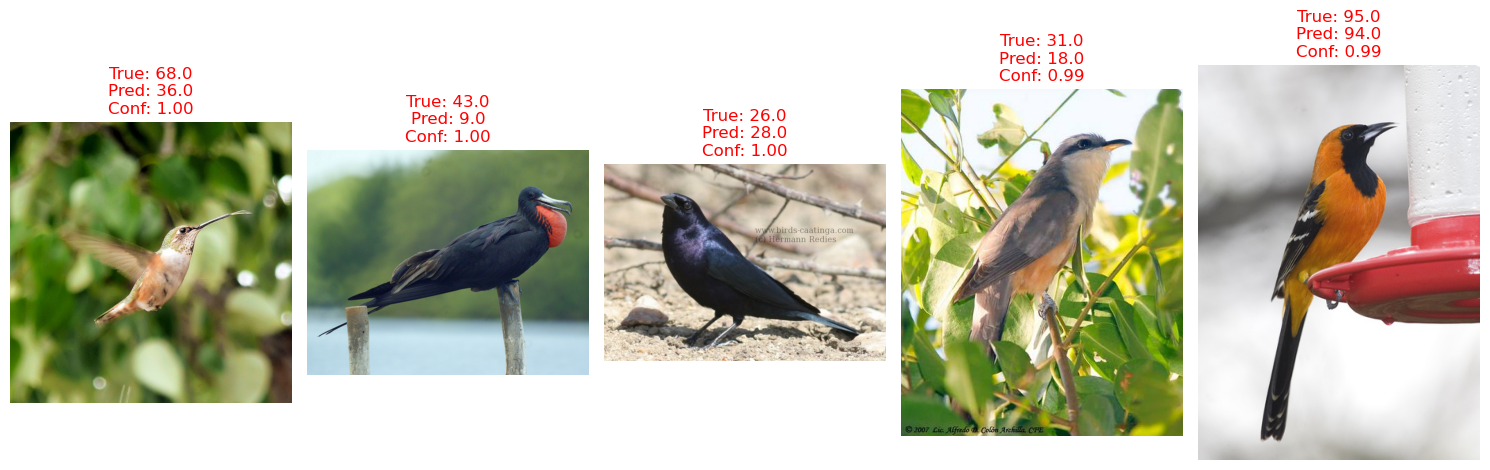

In [7]:
df_errors = pd.DataFrame({
    "True": true_labels,
    "Pred": pred_labels,
    "Confidence": confidences,
    "Index": range(len(true_labels))
})

# Filter for errors
wrong_preds = df_errors[df_errors["True"] != df_errors["Pred"]]

# Sort by confidence
top_wrong = wrong_preds.sort_values(by="Confidence", ascending=False).head(5)

print("Top 5 Most Confident Failures:")
print(top_wrong)

# Visualization (NEED OG DATA FILE!)
raw_val_ds = load_from_disk(DATA_PATH)["validation"]

plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(top_wrong.iterrows()):
    idx = int(row["Index"])
    img = raw_val_ds[idx]["image"]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {row['True']}\nPred: {row['Pred']}\nConf: {row['Confidence']:.2f}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.savefig("error_analysis_top_fails.png")
plt.show()

Now actual confusion matrix (200x200 is hard to had to get creative), so its better to show which pairs of birds are confused most often:

In [8]:
cm = confusion_matrix(true_labels, pred_labels)

np.fill_diagonal(cm, 0)

# Find max confusion
flat_indices = np.argsort(cm.flatten())[-5:] # Top 5 confused pairs
rows, cols = np.unravel_index(flat_indices, cm.shape)

print("\nTop 5 Most Confused Pairs (Model predicts B when it is actually A):")
for r, c in zip(rows, cols):
    print(f"True Class {r} -> Predicted as Class {c} (Count: {cm[r, c]})")


Top 5 Most Confused Pairs (Model predicts B when it is actually A):
True Class 28 -> Predicted as Class 8 (Count: 2)
True Class 64 -> Predicted as Class 61 (Count: 2)
True Class 78 -> Predicted as Class 92 (Count: 2)
True Class 97 -> Predicted as Class 11 (Count: 2)
True Class 55 -> Predicted as Class 34 (Count: 3)
